In [1]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# If we want to consider inf and -inf to be “NA” in computations, we can set 
pd.options.mode.use_inf_as_na = True

In [2]:
train_df = pd.read_csv('data/aps_failure_training_set.csv', skiprows=range(0, 20))
test_df = pd.read_csv('data/aps_failure_test_set.csv', skiprows=range(0, 20))

In [3]:
# replace classes neg to 0, pos to 1
# alternative index accesing train_df.iloc[:,0]
train_df['class'] = train_df['class'].str.replace('neg','0')
train_df['class'] = train_df['class'].str.replace('pos','1')
cols = train_df.columns
train_df[cols] = train_df[cols].apply(pd.to_numeric, errors='coerce')

test_df['class'] = test_df['class'].str.replace('neg','0')
test_df['class'] = test_df['class'].str.replace('pos','1')
cols = test_df.columns
test_df[cols] = test_df[cols].apply(pd.to_numeric, errors='coerce')

In [4]:
# split dataframe into two arrays
cols = train_df.columns.drop('class')
X_train = train_df[cols].values
X_test = test_df[cols].values

# labels
y_train = train_df['class'].values
y_test = test_df['class'].values

In [5]:
# Create our imputer to replace missing values with the mean e.g.
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
# strategy = {mean, median, most_frequent}

imp_train = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_train = imp_train.fit(X_train)
imp_test = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_test = imp_test.fit(X_test)
# Impute each train and test item, then predict
X_train_imp = imp_train.transform(X_train)
X_test_imp = imp_test.transform(X_test)

### Remove outliers

In [6]:
# LocalOutlierFactor
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)

train_out = clf.fit_predict(X_train_imp)
X_train_imp = X_train_imp[train_out > 0]
y_train = y_train[train_out > 0]

test_out = clf.fit_predict(X_test_imp)
X_test_imp = X_test_imp[test_out > 0]
y_test = y_test[test_out > 0]

### Estimate optimal number of features

In [7]:
from time import time
Cost_1 = 10 
Cost_2 = 500
columns = []
costs = []
times_reduce = []
times_train = []
times_pred = []
_ , column = X_train.shape

while column > 0:
    #     dimention reduction 
    t0 = time()
    X_train_new = SelectKBest(chi2, k=column).fit_transform(X_train_imp, y_train)
    X_test_new = SelectKBest(chi2, k=column).fit_transform(X_test_imp, y_test)
    times_reduce.append(round(time()-t0, 3))
    
    #     train the model
    t1 = time()
    neigh = KNeighborsClassifier(n_neighbors=5)
    n_clf = neigh.fit(X_train_new, y_train) 
    times_train.append(round(time()-t1, 3))

    #     test the model
    t2 = time()
    y_pred = n_clf.predict(X_test_new)
    times_pred.append(round(time()-t2, 3))

    #     model evaluation
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    FP = cnf_matrix[0, 1]
    FN = cnf_matrix[1, 0]    
    Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)
    columns.append(column)
    costs.append(Total_cost)
#     print("Total cost:", Total_cost, "Dimentions:", column, "Iter time:", round(time()-t0, 3), "s")
    column = column - 1

### Results visualisation

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\envs\ML36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


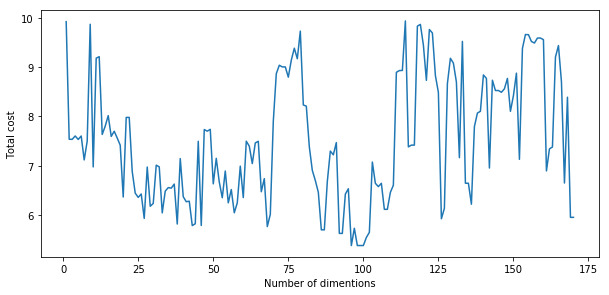

number features with min cost: 96


In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
ax = plt.subplot(211)
ax.plot(columns, costs)
plt.ylabel('Total cost')
plt.xlabel('Number of dimentions')
plt.show()
# number features with min cost
k = columns[costs.index(min(costs))]
print('number features with min cost: {}'.format(k))

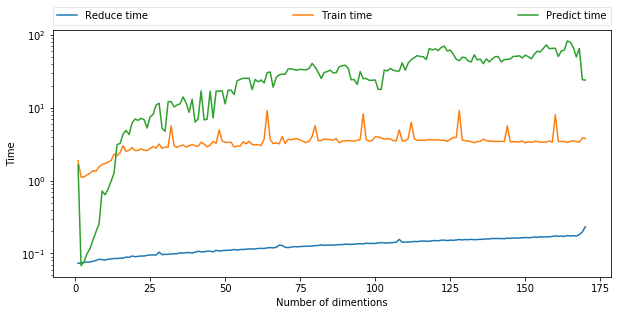

In [9]:
pylab.rcParams['figure.figsize'] = (10, 10)
ax = plt.subplot(211)
ax.plot(columns, times_reduce,  label="Reduce time")
ax.plot(columns, times_train, label="Train time")
ax.plot(columns, times_pred, label="Predict time")
ax.set_yscale('log')
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
leg.get_frame().set_alpha(0.5)
plt.ylabel('Time')
plt.xlabel('Number of dimentions')
plt.show()

In [10]:
print('Class distribution of the training set: {}'.format(Counter(y_train)))

Class distribution of the training set: Counter({0: 53252, 1: 748})
